# N0 Wavelength Study with PML

Having added exact pml, we compare getting N0 results without and with PML

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fiberamp.fiber.microstruct.bragg import BraggExact
from step_exact import plotlogf
from ngsolve.webgui import Draw
from ngsolve import CF
from scipy.optimize import newton

importing NGSolve-6.2.2203-56-g47f483033


# Initialize

In [2]:
n = 300
wls = np.linspace(1.4e-6, 2e-6, n+1)
nu = 1

n_air = 1.00027717
n_glass = 1.4388164768221814

We'll make an instance for use with exact PML and one for without.

In [3]:
d = 4.0775e-05
ts = [d, .5*d]
ns = [lambda x: n_air, lambda x: n_glass]
mats = ['air', 'glass']
maxhs = [.060, .010]
scale = 15e-6

A = BraggExact(ts=ts, maxhs=maxhs, ns=ns, mats=mats, scale=scale)

In [4]:

ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [.06,.01, .02]

pml = {'alpha':.04, 'R0':rhos[-2]}

B = BraggExact(ts=ts, mats=mats, ns=ns, maxhs=maxhs)

Just test them here

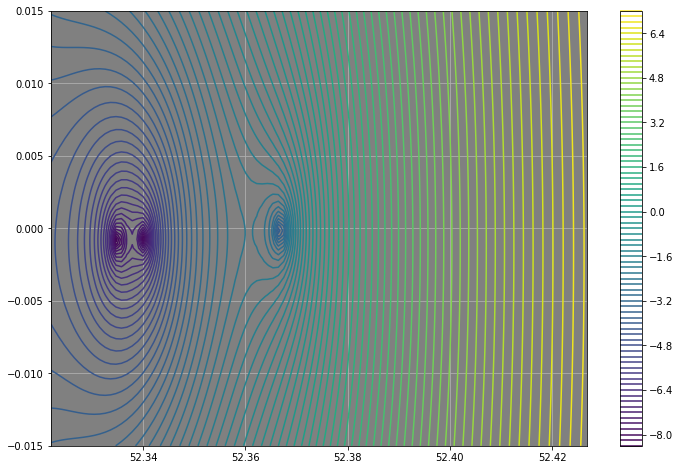

In [5]:
k_low = A.ks[0].real * A.scale

plotlogf(A.determinant, .999*k_low, 1.001 * k_low, -.015,.015, nu, 'h2',
         iref=100, rref=100, levels=100)

In [6]:
guess = np.array(.99998*k_low)
imag = 0
x0 = np.array(guess + imag*1j)

beta = newton(A.determinant, x0, args=(nu, 'h2'), tol = 1e-17)
beta

(52.36692075233395-0.00015576360314173543j)

In [7]:
Fs = A.all_fields(beta, nu, 'h2')

In [8]:
Draw(Fs['Ez'], A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

Now the PML one

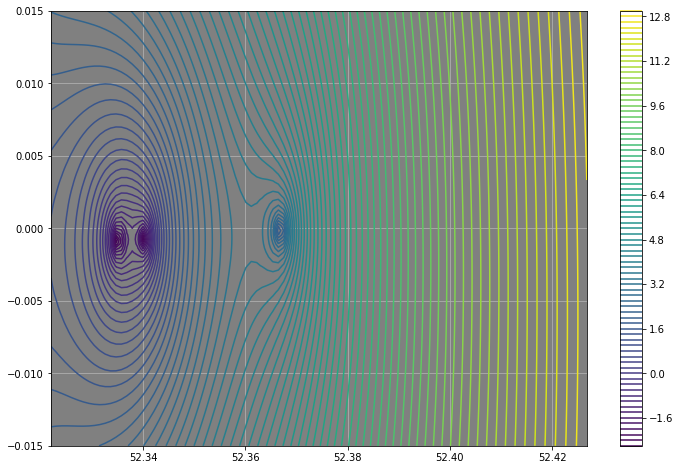

In [9]:
k_low = B.ks[0].real * B.scale

plotlogf(B.determinant, .999*k_low, 1.001 * k_low, -.015,.015, nu, 'pcb',pml,
         iref=100, rref=100, levels=100)

In [10]:
guess = np.array(.9999*k_low)
imag = 0
x0 = np.array(guess + imag*1j)

beta = newton(B.determinant, x0, args=(nu, 'pcb', pml), tol = 1e-17)
beta

(52.36692213594713-0.00015543338509340886j)

In [11]:
Fs = B.all_fields(beta, nu, 'pcb', pml)

In [12]:
Draw(Fs['Ez'], B.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

# Regular Wavelength Loss Study


In [13]:
d = 4.0775e-05
ts = [d, .5*d]
ns = [lambda x: n_air, lambda x: n_glass]
mats = ['air', 'glass']
maxhs = [.060, .010]
scale = 15e-6

betas_reg = np.zeros_like(wls, dtype=complex)
outer = 'h2'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, maxhs=[2,2], wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_reg[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33269141518102-9.422996804515624e-05j) . Residual of determinant:  8.018424657867217e-13 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662248786066-9.449937741749327e-05j) . Residual of determinant:  5.345070836101618e-13 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14082723756141-9.476917132029115e-05j) . Residual of determinant:  4.854636289879224e-14 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04530449638712-9.503934975326443e-05j) . Residual of determinant:  6.592903412427898e-13 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95005310307742-9.530991271613819e-05j) . Residual of determinant:  1.1624534497169988e-14 


     -------------

Scaled beta:  (63.52072963896662-0.00010587623913785886j) . Residual of determinant:  3.8611694575317106e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

Scaled beta:  (63.43522081953923-0.00010616179854290937j) . Residual of determinant:  1.4503788726688125e-13 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled beta:  (63.34994184023984-0.00010644774246626821j) . Residual of determinant:  2.693064410645204e-13 


     --------------------  46/301: wavelength: 1.49e-06  --------------------     

Scaled beta:  (63.26489177553783-0.0001067340709076357j) . Residual of determinant:  2.425225181341017e-13 


     --------------------  47/301: wavelength: 1.4919999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.18006970486518-0.00010702078386665961j) . Residual of determinant:  1.8973610015579423e-13 


     --------------------  48/301: wavelength: 1.494e-06  ---

Scaled beta:  (60.34812868057073-0.00011729798124274516j) . Residual of determinant:  6.943997490013843e-13 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.2709405749485-0.00011759853663714025j) . Residual of determinant:  3.2317951761489866e-14 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.19394960806164-0.0001178994765379187j) . Residual of determinant:  7.76032633574721e-14 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

Scaled beta:  (60.11715502555279-0.00011820080094476849j) . Residual of determinant:  3.633029698674889e-14 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.04055607690848-0.00011850250985733784j) . Residual of determinant:  1.5574015988957287e-13 


     --------------------  87/301: waveleng

scaling guess: 2
Scaled beta:  (57.267715051116745-0.00013025236414495578j) . Residual of determinant:  7.28337473486123e-14 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

Scaled beta:  (57.198198811627464-0.0001305690685319372j) . Residual of determinant:  1.3344167382409495e-13 


     --------------------  126/301: wavelength: 1.6499999999999999e-06  --------------------     

Scaled beta:  (57.12885107625932-0.00013088615741174527j) . Residual of determinant:  2.032361184273908e-13 


     --------------------  127/301: wavelength: 1.652e-06  --------------------     

Scaled beta:  (57.05967123301198-0.00013120363078405006j) . Residual of determinant:  6.308125247104513e-14 


     --------------------  128/301: wavelength: 1.654e-06  --------------------     

scaling guess: 1
Scaled beta:  (56.99065867284514-0.00013152148864851906j) . Residual of determinant:  6.494855942244123e-14 


     --------------------  129/301: wavelength: 1.656

scaling guess: 2
Scaled beta:  (54.54948561932455-0.00014355252455303816j) . Residual of determinant:  1.755894288443238e-13 


     --------------------  166/301: wavelength: 1.73e-06  --------------------     

Scaled beta:  (54.4864060452228-0.00014388499286964638j) . Residual of determinant:  9.96013288958422e-14 


     --------------------  167/301: wavelength: 1.7319999999999999e-06  --------------------     

Scaled beta:  (54.423472132289284-0.0001442178456651691j) . Residual of determinant:  6.960221016375149e-13 


     --------------------  168/301: wavelength: 1.7339999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.36068337650614-0.00014455108293919485j) . Residual of determinant:  3.8841447181873613e-13 


     --------------------  169/301: wavelength: 1.736e-06  --------------------     

Scaled beta:  (54.29803927617827-0.00014488470469144806j) . Residual of determinant:  2.4870259375434373e-13 


     --------------------  170/301: wavele

Scaled beta:  (52.02002072000574-0.00015784722613143524j) . Residual of determinant:  6.595917160084031e-14 


     --------------------  208/301: wavelength: 1.814e-06  --------------------     

Scaled beta:  (51.96265019866252-0.00015819584225677702j) . Residual of determinant:  7.447499862699896e-14 


     --------------------  209/301: wavelength: 1.8159999999999999e-06  --------------------     

Scaled beta:  (51.905406025853296-0.00015854484284602845j) . Residual of determinant:  1.8709187044186007e-13 


     --------------------  210/301: wavelength: 1.8179999999999998e-06  --------------------     

Scaled beta:  (51.84828778458623-0.00015889422789880145j) . Residual of determinant:  1.9709553099395345e-13 


     --------------------  211/301: wavelength: 1.82e-06  --------------------     

Scaled beta:  (51.79129505970249-0.0001592439974147328j) . Residual of determinant:  7.742078188548324e-14 


     --------------------  212/301: wavelength: 1.8219999999999999e-06  --

Scaled beta:  (49.7146547818563-0.00017282012256394222j) . Residual of determinant:  1.1709920635273367e-13 


     --------------------  250/301: wavelength: 1.8979999999999999e-06  --------------------     

Scaled beta:  (49.66225183879597-0.00017318488585309005j) . Residual of determinant:  1.417350380760621e-13 


     --------------------  251/301: wavelength: 1.9e-06  --------------------     

Scaled beta:  (49.609959200277856-0.00017355003359041812j) . Residual of determinant:  1.470898198525388e-13 


     --------------------  252/301: wavelength: 1.9019999999999997e-06  --------------------     

Scaled beta:  (49.55777651833818-0.00017391556577552644j) . Residual of determinant:  6.508933690734948e-13 


     --------------------  253/301: wavelength: 1.904e-06  --------------------     

scaling guess: 1
Scaled beta:  (49.50570344647513-0.00017428148240802144j) . Residual of determinant:  6.620275727390821e-14 


     --------------------  254/301: wavelength: 1.905999999

<IPython.core.display.Javascript object>


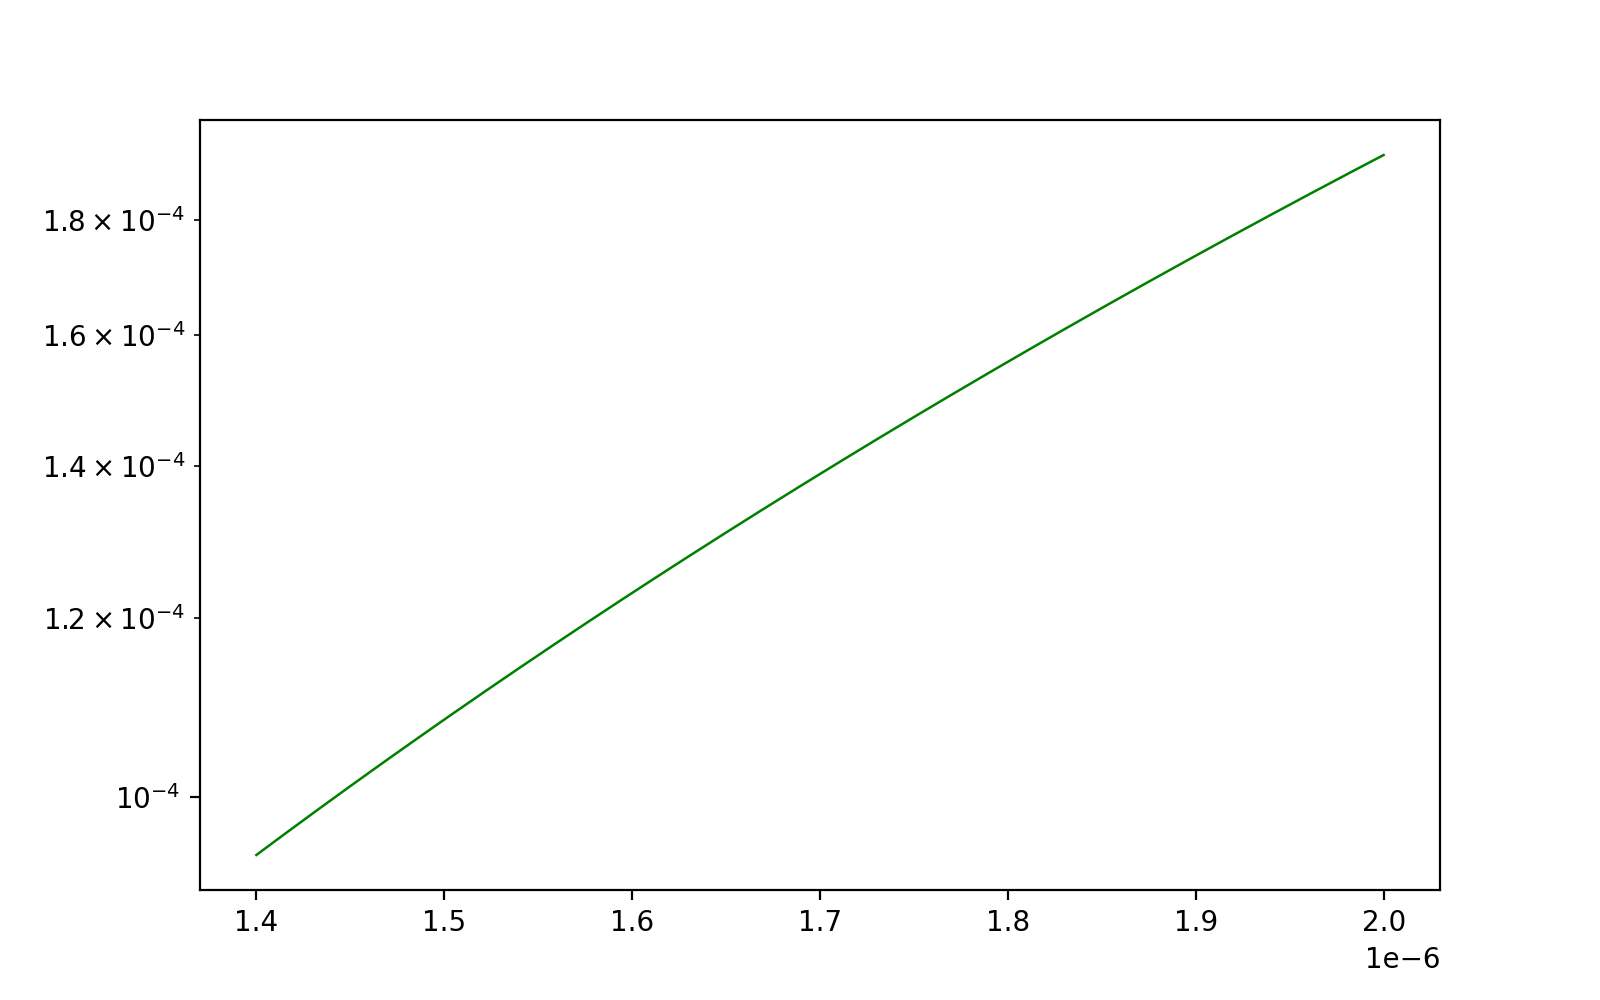

In [14]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, -betas_reg.imag, color='green', linewidth=.9)
plt.yscale('log')


In [52]:
# np.save('../N2_varying_thickness_studies/data/N0_betas', betas1)

# Exact PML Wavelength Loss Study


In [28]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.028, 'R0':rhos[-2]}

betas_pml = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33269204634014-9.548404625127524e-05j) . Residual of determinant:  1.9774992677836117e-10 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662350751032-9.546314293295515e-05j) . Residual of determinant:  1.3430422080792723e-10 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.1408285148993-9.533106367144115e-05j) . Residual of determinant:  6.145779917215049e-11 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.04530587528164-9.514635314864437e-05j) . Residual of determinant:  2.932727118313982e-11 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95005442777907-9.496783329380728e-05j) . Residual of determinant:  7.9992758

scaling guess: 1
Scaled beta:  (63.86508164992752-0.00010664072398057464j) . Residual of determinant:  4.585423696207228e-11 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

Scaled beta:  (63.77864472945189-0.00010695872257134179j) . Residual of determinant:  1.5863123741833368e-10 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.692441380384196-0.00010707227353256282j) . Residual of determinant:  5.3761854478004077e-11 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60647058631224-0.00010700391707836768j) . Residual of determinant:  4.721270372082251e-11 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.5207313520964-0.00010680098917644778j) . Residual of determinant:  6.453055051139256e-11 


     --------------------  44/301: wavelength: 1.48599999

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (60.73705089118595-0.00011477269300034463j) . Residual of determinant:  2.6405226308677667e-11 


     --------------------  78/301: wavelength: 1.5539999999999999e-06  --------------------     

Scaled beta:  (60.658865375888006-0.0001156325966873029j) . Residual of determinant:  2.1605025189068066e-11 


     --------------------  79/301: wavelength: 1.556e-06  --------------------     

Scaled beta:  (60.58088098127816-0.00011657439042537272j) . Residual of determinant:  5.1865804935146196e-11 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

Scaled beta:  (60.50309696560075-0.00011755482550486765j) . Residual of determinant:  4.309846801322311e-11 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.42551257645484-0.00011851558567070163j) . Residual of determinant:  5.2526379748890807e-11 


     --

scaling guess: 1
Scaled beta:  (57.829988492444684-0.0001267733851077016j) . Residual of determinant:  9.3437945158308e-12 


     --------------------  117/301: wavelength: 1.6319999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.759101467176095-0.00012644282188154908j) . Residual of determinant:  3.6521567375519215e-11 


     --------------------  118/301: wavelength: 1.634e-06  --------------------     

Scaled beta:  (57.68838783365968-0.00012623765382966797j) . Residual of determinant:  9.49097044789722e-12 


     --------------------  119/301: wavelength: 1.6359999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.61784699560758-0.0001261665118392037j) . Residual of determinant:  1.4310854268485925e-11 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (57.547

Scaled beta:  (55.253117632191135-0.0001382990158423551j) . Residual of determinant:  5.233676575385709e-12 


     --------------------  155/301: wavelength: 1.708e-06  --------------------     

scaling guess: 1
Scaled beta:  (55.1884014523936-0.0001393823884663357j) . Residual of determinant:  4.156049330301706e-11 


     --------------------  156/301: wavelength: 1.71e-06  --------------------     

scaling guess: 1
Scaled beta:  (55.12383679931807-0.00014058108924411804j) . Residual of determinant:  9.97883743575409e-12 


     --------------------  157/301: wavelength: 1.7119999999999999e-06  --------------------     

Scaled beta:  (55.05942318426047-0.0001418575990933007j) . Residual of determinant:  5.364033249673457e-12 


     --------------------  158/301: wavelength: 1.714e-06  --------------------     

Scaled beta:  (54.99516011074888-0.00014315729691092064j) . Residual of determinant:  2.9667453036215043e-12 


     --------------------  159/301: wavelength: 1.716e-06 

Scaled beta:  (52.83671346877653-0.00015862960774101192j) . Residual of determinant:  9.98811451487017e-14 


     --------------------  194/301: wavelength: 1.786e-06  --------------------     

Scaled beta:  (52.777530489714884-0.00015863564663097055j) . Residual of determinant:  1.5699656329544022e-11 


     --------------------  195/301: wavelength: 1.7879999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.71847976634456-0.0001583478884495624j) . Residual of determinant:  3.3542858714493866e-11 


     --------------------  196/301: wavelength: 1.7899999999999998e-06  --------------------     

Scaled beta:  (52.659560783115005-0.00015781778995736616j) . Residual of determinant:  7.92586396816858e-12 


     --------------------  197/301: wavelength: 1.792e-06  --------------------     

Scaled beta:  (52.60077304780426-0.00015711424689935708j) . Residual of determinant:  5.441794014504301e-12 


     --------------------  198/301: wavelength: 1.7939999

Scaled beta:  (50.62273221379527-0.00016621029308711027j) . Residual of determinant:  1.0450354238914434e-12 


     --------------------  233/301: wavelength: 1.8639999999999999e-06  --------------------     

Scaled beta:  (50.568399058149836-0.00016539143122352323j) . Residual of determinant:  3.0636316437428045e-12 


     --------------------  234/301: wavelength: 1.8659999999999998e-06  --------------------     

Scaled beta:  (50.51418215513733-0.00016471650342507585j) . Residual of determinant:  1.961059198226697e-11 


     --------------------  235/301: wavelength: 1.868e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.46008118193531-0.0001642101162230523j) . Residual of determinant:  3.128091324137609e-12 


     --------------------  236/301: wavelength: 1.8699999999999999e-06  --------------------     

Scaled beta:  (50.406095816018606-0.0001638802340354768j) . Residual of determinant:  8.665086915934478e-12 


     --------------------  237/301: wavelen

scaling guess: 2
Scaled beta:  (48.58674977584733-0.00017587135363986161j) . Residual of determinant:  2.8706367587644985e-12 


     --------------------  272/301: wavelength: 1.9419999999999998e-06  --------------------     

Scaled beta:  (48.53669441248752-0.0001756916390741221j) . Residual of determinant:  8.638590606642216e-12 


     --------------------  273/301: wavelength: 1.944e-06  --------------------     

Scaled beta:  (48.48674201444117-0.00017567464217237768j) . Residual of determinant:  1.3135602202743694e-11 


     --------------------  274/301: wavelength: 1.9459999999999997e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.43689228672924-0.00017579575187524728j) . Residual of determinant:  8.430270034195362e-12 


     --------------------  275/301: wavelength: 1.948e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.38714492341472-0.0001760298114142642j) . Residual of determinant:  1.8512192519576016e-11 


     ------------------

Load cluster results

In [29]:
cluster_betas = np.load('/home/pv/local/convergence/bragg_fiber/wavelength/N0/clean_betas_im.npy')
# exact_scaled_betas = np.load('/home/pv/local/convergence/bragg_fiber/wavelength/N0/exact_scaled_betas.npy')

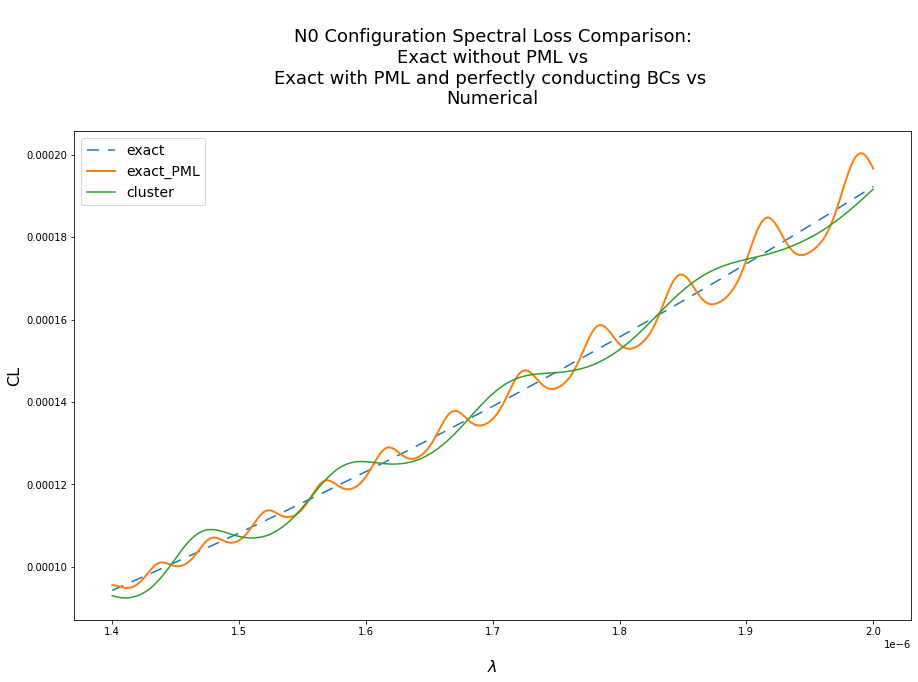

In [30]:
%matplotlib inline
plt.figure(figsize=(15,9))
plt.title('\nN0 Configuration Spectral Loss Comparison:\nExact without PML vs\nExact with PML and perfectly conducting BCs vs \nNumerical\n',
         fontsize=18)
plt.plot(wls, -betas_reg.imag, linewidth=1.5, linestyle=(0,(8,6)), label='exact')
plt.plot(wls, -betas_pml.imag, linewidth=2, label='exact_PML')
plt.ylabel('CL', fontsize=16)
plt.xlabel('\n$\lambda$', fontsize=16)
plt.plot(wls, cluster_betas * A.scale, linewidth=1.5, label='cluster')
# plt.yscale('log')
plt.legend(fontsize=14);

# Repeat for several alpha values for PML

In [18]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.01, 'R0':rhos[-2]}

betas_pml2 = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml2[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.3327088088695-0.00011694589109902003j) . Residual of determinant:  5.786963296041649e-12 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.23664644700965-0.00010567847964225336j) . Residual of determinant:  2.7610816748047324e-12 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14085097433171-9.446562994536437e-05j) . Residual of determinant:  3.320086639800653e-13 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04532346900504-8.622149327591142e-05j) . Residual of determinant:  1.3986899030383076e-13 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95006521265977-8.1861677359852e-05j) . Residual of determ

Scaled beta:  (63.86507125063559-0.00013977125421282499j) . Residual of determinant:  8.365690529519706e-12 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

Scaled beta:  (63.77865092696961-0.00014167786865635542j) . Residual of determinant:  4.31871932112334e-12 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (63.692461983020344-0.00013419251867816565j) . Residual of determinant:  2.880491609724355e-13 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60649873235161-0.00012135396720261429j) . Residual of determinant:  1.4794320644892705e-14 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.52075987317026-0.00010823388138009233j) . Residual of determinant:  8.875238725993988e-12 


     -------------------

scaling guess: 1
Scaled beta:  (60.737044911939336-9.611812212324223e-05j) . Residual of determinant:  2.1147359413882324e-12 


     --------------------  78/301: wavelength: 1.5539999999999999e-06  --------------------     

Scaled beta:  (60.65885115497455-9.717888229510157e-05j) . Residual of determinant:  2.605578724261817e-12 


     --------------------  79/301: wavelength: 1.556e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (60.58085819903724-0.00010207575777814793j) . Residual of determinant:  2.530944845201822e-12 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.50306679743832-0.00011106836313326542j) . Residual of determinant:  1.8312747596069698e-12 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.42547814216246-0.00012400632784687326j) . Residual of determinant:  1

Scaled beta:  (57.830003108663945-0.00010290869264109004j) . Residual of determinant:  1.2324888226166118e-12 


     --------------------  117/301: wavelength: 1.6319999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.75910698495166-0.00010260912810772204j) . Residual of determinant:  4.5292217728436575e-12 


     --------------------  118/301: wavelength: 1.634e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.68838569934332-0.00010563265763547827j) . Residual of determinant:  4.049357232643159e-12 


     --------------------  119/301: wavelength: 1.6359999999999999e-06  --------------------     

Scaled beta:  (57.61783987716083-0.00011130243101162017j) . Residual of determinant:  6.0192603053189096e-12 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

Scaled beta:  (57.54747008024355-0.00011817893297936134j) . Residual of determinant:  1.9165179741651277e-13 


     ------------------

Scaled beta:  (55.253109797034064-0.00011152906916337569j) . Residual of determinant:  3.002443938861655e-12 


     --------------------  155/301: wavelength: 1.708e-06  --------------------     

scaling guess: 1
Scaled beta:  (55.188383735969836-0.00011263594670862483j) . Residual of determinant:  3.525820300094653e-13 


     --------------------  156/301: wavelength: 1.71e-06  --------------------     

scaling guess: 1
Scaled beta:  (55.12380877059903-0.00011743400422469286j) . Residual of determinant:  1.225717450096083e-12 


     --------------------  157/301: wavelength: 1.7119999999999999e-06  --------------------     

Scaled beta:  (55.05938543781091-0.00012619912887758194j) . Residual of determinant:  2.292760238947299e-12 


     --------------------  158/301: wavelength: 1.714e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.99511458153682-0.0001391268908709187j) . Residual of determinant:  2.294441884019121e-12 


     --------------------  159/301: w

Scaled beta:  (52.8367292844735-0.00023010948428884304j) . Residual of determinant:  4.003526351160919e-13 


     --------------------  194/301: wavelength: 1.786e-06  --------------------     

Scaled beta:  (52.77756921049697-0.00021816534143707442j) . Residual of determinant:  6.9807089939067876e-12 


     --------------------  195/301: wavelength: 1.7879999999999999e-06  --------------------     

Scaled beta:  (52.718533058757686-0.00019901494354037334j) . Residual of determinant:  2.3384243601197234e-13 


     --------------------  196/301: wavelength: 1.7899999999999998e-06  --------------------     

Scaled beta:  (52.6596195699967-0.00017796428488124974j) . Residual of determinant:  2.6140603446719355e-12 


     --------------------  197/301: wavelength: 1.792e-06  --------------------     

Scaled beta:  (52.60083005695742-0.00015872882411590954j) . Residual of determinant:  3.030755943531496e-12 


     --------------------  198/301: wavelength: 1.7939999999999999e-06  -

Scaled beta:  (50.622769641257975-0.0001328330520592496j) . Residual of determinant:  1.5794650203179762e-13 


     --------------------  233/301: wavelength: 1.8639999999999999e-06  --------------------     

Scaled beta:  (50.56842472330827-0.0001273043616057491j) . Residual of determinant:  2.6568523246537547e-12 


     --------------------  234/301: wavelength: 1.8659999999999998e-06  --------------------     

Scaled beta:  (50.51419615867679-0.00012519566185512202j) . Residual of determinant:  1.2118822757425895e-12 


     --------------------  235/301: wavelength: 1.868e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.460084212731445-0.0001263438533783262j) . Residual of determinant:  2.79626051445371e-12 


     --------------------  236/301: wavelength: 1.8699999999999999e-06  --------------------     

Scaled beta:  (50.406089234958216-0.0001306193454809185j) . Residual of determinant:  6.686121166293569e-13 


     --------------------  237/301: waveleng

Scaled beta:  (48.586741751915696-0.00013795191605855018j) . Residual of determinant:  4.34557340278114e-12 


     --------------------  272/301: wavelength: 1.9419999999999998e-06  --------------------     

Scaled beta:  (48.53667824610164-0.00014537742839136023j) . Residual of determinant:  3.3354897134362632e-12 


     --------------------  273/301: wavelength: 1.944e-06  --------------------     

Scaled beta:  (48.48672081500647-0.0001552490564672687j) . Residual of determinant:  2.0264728005540263e-13 


     --------------------  274/301: wavelength: 1.9459999999999997e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.43687031495115-0.0001664727504036728j) . Residual of determinant:  2.0727837853528956e-13 


     --------------------  275/301: wavelength: 1.948e-06  --------------------     

Scaled beta:  (48.38712720028825-0.00017706058522911144j) . Residual of determinant:  1.1663362476418685e-12 


     --------------------  276/301: wavelength: 1.95e-06

In [19]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.02, 'R0':rhos[-2]}

betas_pml3 = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml3[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33269370980227-9.838072750453126e-05j) . Residual of determinant:  1.9392987916432227e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662608632208-9.74583460890443e-05j) . Residual of determinant:  3.309288860991634e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14083152426281-9.619105169077098e-05j) . Residual of determinant:  9.438121535349667e-12 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04530882548835-9.489017896391315e-05j) . Residual of determinant:  4.7753794985221194e-11 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95005694355632-9.380801097635708e-05j) . Residual of determinant:  1.529222016267072e-11 


     -------------

Scaled beta:  (63.86508069698221-0.00011087514280498652j) . Residual of determinant:  5.126252116852185e-12 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

Scaled beta:  (63.77864536306552-0.00011130108622991145j) . Residual of determinant:  9.258961513173353e-12 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (63.69244350730668-0.00011087890769486014j) . Residual of determinant:  1.5786646859811395e-11 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60647383978833-0.00010975559782100462j) . Residual of determinant:  6.572659532274794e-12 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.52073520106156-0.0001082133660449276j) . Residual of determinant:  5.233987800335842e-12 


     ---

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.73704802245407-0.00011237560646914676j) . Residual of determinant:  1.9889039387491223e-11 


     --------------------  78/301: wavelength: 1.5539999999999999e-06  --------------------     

Scaled beta:  (60.6588616494174-0.00011391353967456963j) . Residual of determinant:  1.5661021165349454e-12 


     --------------------  79/301: wavelength: 1.556e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.580876557649404-0.00011591513789120062j) . Residual of determinant:  3.263221361768135e-11 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (60.503092195847515-0.00011828749764648061j) . Residual of determinant:  5.586233050962267e-12 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.42550797758107-0.00012082519235483061j) . Residual of determinant: 

Scaled beta:  (57.75910462026762-0.00012304983685760653j) . Residual of determinant:  2.7113505945701863e-11 


     --------------------  118/301: wavelength: 1.634e-06  --------------------     

Scaled beta:  (57.688389942860844-0.0001225653495080602j) . Residual of determinant:  1.3489634109052495e-11 


     --------------------  119/301: wavelength: 1.6359999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.61784821899798-0.000122498919255972j) . Residual of determinant:  3.7936409127300815e-12 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

Scaled beta:  (57.547478904730355-0.00012270996827262623j) . Residual of determinant:  1.3931626308987806e-11 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

Scaled beta:  (57.47728137326-0.00012305365059291624j) . Residual of determinant:  9.63968421279211e-12 


     --------------------  122/301: wavelength: 1.642e-06  -

Scaled beta:  (55.188396278821635-0.0001364615034963043j) . Residual of determinant:  2.3518121621218276e-11 


     --------------------  156/301: wavelength: 1.71e-06  --------------------     

Scaled beta:  (55.12383055117992-0.00013884318520133128j) . Residual of determinant:  1.8794046684467726e-11 


     --------------------  157/301: wavelength: 1.7119999999999999e-06  --------------------     

Scaled beta:  (55.05941617288511-0.00014174430071473427j) . Residual of determinant:  3.062747972437291e-13 


     --------------------  158/301: wavelength: 1.714e-06  --------------------     

Scaled beta:  (54.99515283509208-0.0001450080376721878j) . Residual of determinant:  3.3561357677595312e-12 


     --------------------  159/301: wavelength: 1.716e-06  --------------------     

Scaled beta:  (54.93104017489033-0.00014838318009403702j) . Residual of determinant:  1.801372197439581e-11 


     --------------------  160/301: wavelength: 1.718e-06  --------------------     

S

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (52.83671526682064-0.00016885006471045107j) . Residual of determinant:  3.990096968343092e-12 


     --------------------  194/301: wavelength: 1.786e-06  --------------------     

Scaled beta:  (52.77753496575128-0.00016793126762617167j) . Residual of determinant:  2.6169793934331958e-12 


     --------------------  195/301: wavelength: 1.7879999999999999e-06  --------------------     

Scaled beta:  (52.718486455767426-0.00016596941165907938j) . Residual of determinant:  3.0691239513399567e-12 


     --------------------  196/301: wavelength: 1.7899999999999998e-06  --------------------     

Scaled beta:  (52.65956901330987-0.00016324948731270226j) . Residual of determinant:  8.576787243010016e-15 


     --------------------  197/301: wavelength: 1.792e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (52.60078205368062-0.00016011878944899866j) . Residual of determina

Scaled beta:  (50.62274104266901-0.00016282332781994812j) . Residual of determinant:  6.975501599692076e-12 


     --------------------  233/301: wavelength: 1.8639999999999999e-06  --------------------     

Scaled beta:  (50.56840640918236-0.00016050194980287577j) . Residual of determinant:  3.826480574179713e-12 


     --------------------  234/301: wavelength: 1.8659999999999998e-06  --------------------     

Scaled beta:  (50.514187857936996-0.0001588627174856098j) . Residual of determinant:  1.089337996288669e-11 


     --------------------  235/301: wavelength: 1.868e-06  --------------------     

Scaled beta:  (50.46008523927744-0.00015790857258624562j) . Residual of determinant:  6.460009416692964e-12 


     --------------------  236/301: wavelength: 1.8699999999999999e-06  --------------------     

Scaled beta:  (50.40609838083761-0.0001575771099576929j) . Residual of determinant:  8.264541671968504e-12 


     --------------------  237/301: wavelength: 1.8719999999999

Scaled beta:  (48.58675241737365-0.00016858219982946265j) . Residual of determinant:  7.267915820116988e-12 


     --------------------  272/301: wavelength: 1.9419999999999998e-06  --------------------     

Scaled beta:  (48.53669570498001-0.00016884908663936704j) . Residual of determinant:  1.603544890396411e-13 


     --------------------  273/301: wavelength: 1.944e-06  --------------------     

Scaled beta:  (48.48674232266187-0.00016949336975509007j) . Residual of determinant:  5.437599839538962e-12 


     --------------------  274/301: wavelength: 1.9459999999999997e-06  --------------------     

Scaled beta:  (48.436891997027494-0.0001703360429489501j) . Residual of determinant:  1.5325211287518664e-11 


     --------------------  275/301: wavelength: 1.948e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.387144385842085-0.00017119902516529237j) . Residual of determinant:  1.3977626090128571e-12 


     --------------------  276/301: wavelength: 1.95e-0

In [20]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.03, 'R0':rhos[-2]}

betas_pml4 = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml4[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33269188223382-9.516949764603397e-05j) . Residual of determinant:  1.6541919869532903e-10 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662324542069-9.522810824833536e-05j) . Residual of determinant:  2.333785534426614e-10 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14082819295164-9.52029961753689e-05j) . Residual of determinant:  1.9886900458793648e-10 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04530553664827-9.513450218000006e-05j) . Residual of determinant:  2.6254539483668853e-11 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.9500541122529-9.50647013196765e-05j) . Residual of determinant:  5.376756429040842e-11 


     --------------

scaling guess: 2
Scaled beta:  (63.69244116534132-0.00010664654530364402j) . Residual of determinant:  3.891703294125579e-11 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60647024867615-0.00010667277157959478j) . Residual of determinant:  3.7556620013547515e-12 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.520730934083886-0.00010659704704792431j) . Residual of determinant:  1.3781665087555736e-11 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.435222262139696-0.00010646184888125391j) . Residual of determinant:  8.360158831779268e-11 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.349943295929585-0.00010631242056166626j) . Residual of determinant:  8.357788484147141e-11 


     --------------------  46/301: w

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.5808815324618-0.00011657068017209077j) . Residual of determinant:  1.1395920201506917e-11 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.503097517731135-0.00011739172306195859j) . Residual of determinant:  2.954382096805224e-11 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.42551307832911-0.0001181899609265045j) . Residual of determinant:  1.6614738802155943e-11 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.34812744161882-0.00011891770646591458j) . Residual of determinant:  2.4803286832553488e-12 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scaled beta:  (60.270939821431796-0.00011952944650076223j) . Residual of determinant:  2.0434073193457638e-11 


     --

scaling guess: 1
Scaled beta:  (57.68838743747365-0.00012670020426978866j) . Residual of determinant:  3.674700864895768e-11 


     --------------------  119/301: wavelength: 1.6359999999999999e-06  --------------------     

Scaled beta:  (57.6178467173867-0.00012668492556511975j) . Residual of determinant:  7.40438634603182e-11 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.54747818965913-0.00012677591650992696j) . Residual of determinant:  2.6771339592298476e-11 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.477281245071296-0.00012697229492881565j) . Residual of determinant:  3.084199364263043e-11 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

Scaled beta:  (57.40725527298338-0.00012727186135417644j) . Residual of determinant:  6.33445507666830

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.99516096639797-0.0001428079666230332j) . Residual of determinant:  1.5061821854055906e-11 


     --------------------  159/301: wavelength: 1.716e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (54.93104783921353-0.00014384204070440782j) . Residual of determinant:  1.1992913231994862e-11 


     --------------------  160/301: wavelength: 1.718e-06  --------------------     

Scaled beta:  (54.86708414524034-0.00014477872068724312j) . Residual of determinant:  4.209402409176558e-12 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

Scaled beta:  (54.80326933635989-0.00014556768551352405j) . Residual of determinant:  5.370137564582709e-11 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

Scaled beta:  (54.73960285072656-0.00014616792082817833j) . Residual of determinant:  4.927571699099

scaling guess: 1
Scaled beta:  (52.54211497977457-0.0001560770159667934j) . Residual of determinant:  1.1538605346931618e-11 


     --------------------  199/301: wavelength: 1.7959999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (52.48358838358309-0.00015551304653728195j) . Residual of determinant:  2.1106895261238513e-11 


     --------------------  200/301: wavelength: 1.798e-06  --------------------     

Scaled beta:  (52.42519177408042-0.0001549720206694061j) . Residual of determinant:  2.54834219304616e-11 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

Scaled beta:  (52.36692474002087-0.0001544960445738056j) . Residual of determinant:  4.4746500184248756e-13 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.3087868798226-0.00015411607730191908j) . Residual of determinant:  1.

Scaled beta:  (50.40609519776359-0.00016471888253909866j) . Residual of determinant:  5.813281863010437e-12 


     --------------------  237/301: wavelength: 1.8719999999999998e-06  --------------------     

Scaled beta:  (50.352225277092444-0.0001646033994656712j) . Residual of determinant:  1.724281996910356e-11 


     --------------------  238/301: wavelength: 1.8739999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.298470285175036-0.00016461413466042048j) . Residual of determinant:  5.6261602230137205e-12 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

Scaled beta:  (50.24482987357885-0.00016474080217564378j) . Residual of determinant:  4.902693086176064e-13 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

Scaled beta:  (50.191303688171175-0.0001649722409820207j) . Residual of determinant:  2.8012581046353908e-11 


     --------------------  241/301: wavele

Scaled beta:  (48.387144834979004-0.0001770236876023952j) . Residual of determinant:  2.0576011770684446e-12 


     --------------------  276/301: wavelength: 1.95e-06  --------------------     

Scaled beta:  (48.337499621529155-0.00017733282296123498j) . Residual of determinant:  8.303467968783591e-12 


     --------------------  277/301: wavelength: 1.952e-06  --------------------     

Scaled beta:  (48.287956126988426-0.00017772762721909128j) . Residual of determinant:  8.336448569130984e-12 


     --------------------  278/301: wavelength: 1.954e-06  --------------------     

Scaled beta:  (48.23851403637096-0.00017820595283779428j) . Residual of determinant:  6.349563917146865e-12 


     --------------------  279/301: wavelength: 1.956e-06  --------------------     

Scaled beta:  (48.18917303649526-0.0001787718165549931j) . Residual of determinant:  9.521330034344155e-12 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

S

In [21]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.04, 'R0':rhos[-2]}

betas_pml5 = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml5[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33269152505704-9.445775352534047e-05j) . Residual of determinant:  5.427678342010165e-10 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662266800272-9.468013146780489e-05j) . Residual of determinant:  3.439640237996985e-10 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14082746870307-9.488211175978454e-05j) . Residual of determinant:  7.943054161259201e-10 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.04530475356819-9.507136326750535e-05j) . Residual of determinant:  8.393695171214067e-10 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (66.95005335862881-9.525685082607589e-05j) . Residual of determi

Scaled beta:  (63.865081939905444-0.00010510832923538337j) . Residual of determinant:  6.156391600776356e-10 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.778644517917535-0.00010539854988798166j) . Residual of determinant:  5.202055054886094e-10 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

Scaled beta:  (63.69244068582176-0.00010565443321731947j) . Residual of determinant:  8.929905373727605e-12 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.6064694873133-0.00010587843788358206j) . Residual of determinant:  2.8063653244424925e-10 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.52072997260034-0.00010607624214017559j) . Residual of determinant:  4.290836977330043e-10 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  ---

Scaled beta:  (60.503098840374385-0.00011691539852180894j) . Residual of determinant:  9.3219756037446e-12 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.42551424905849-0.00011734645219365455j) . Residual of determinant:  3.143457652461434e-10 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.348128351119186-0.00011775563971267759j) . Residual of determinant:  1.435333084039912e-11 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scaled beta:  (60.27094037741715-0.00011813378877006474j) . Residual of determinant:  1.6495301397723134e-10 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.19394956012107-0.00011847401742216696j) . Residual of determinant:  4.782828875325893e-10 


     --------------------  85/301: wavelengt

Scaled beta:  (57.617845868820986-0.00012805981877128957j) . Residual of determinant:  6.436446234104233e-11 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.54747766837402-0.00012828753710232476j) . Residual of determinant:  7.847862670140796e-11 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

Scaled beta:  (57.477281061253414-0.0001285536350486896j) . Residual of determinant:  4.775132444453985e-11 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

Scaled beta:  (57.407255429039004-0.0001288603903314501j) . Residual of determinant:  5.534815572366143e-11 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.33740015650278-0.00012920841512046146j) . Residual of determinant:  1.760608517201878e-10 


     -------------------

Scaled beta:  (54.995163073283834-0.0001417746697562506j) . Residual of determinant:  9.994697119623558e-11 


     --------------------  159/301: wavelength: 1.716e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.931049693276854-0.00014230306180004206j) . Residual of determinant:  5.417286590239933e-11 


     --------------------  160/301: wavelength: 1.718e-06  --------------------     

Scaled beta:  (54.86708561304797-0.00014279894343416605j) . Residual of determinant:  2.914593548316075e-10 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.803270303560836-0.00014325193572653982j) . Residual of determinant:  1.3227235787543369e-10 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.73960323555622-0.00014365394814748708j) . Residual of determinant:  8.7248914930

Scaled beta:  (52.6007693597794-0.00015516272264584762j) . Residual of determinant:  8.15486577119696e-12 


     --------------------  198/301: wavelength: 1.7939999999999999e-06  --------------------     

Scaled beta:  (52.54211214435088-0.00015524789728020653j) . Residual of determinant:  4.805487267288689e-11 


     --------------------  199/301: wavelength: 1.7959999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (52.48358549286406-0.00015531284415199741j) . Residual of determinant:  3.5979118472310484e-11 


     --------------------  200/301: wavelength: 1.798e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.4251889676601-0.00015537052405930777j) . Residual of determinant:  9.827473374946795e-11 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.36692213594713-0.00015543338509340767j) . Residual of determinant:  1.5234758711056376e-11 


     -----

Scaled beta:  (50.406093128866495-0.0001669591886625819j) . Residual of determinant:  9.923836842591775e-12 


     --------------------  237/301: wavelength: 1.8719999999999998e-06  --------------------     

Scaled beta:  (50.35222365302414-0.00016709692741756398j) . Residual of determinant:  1.1431293068589116e-10 


     --------------------  238/301: wavelength: 1.8739999999999998e-06  --------------------     

Scaled beta:  (50.29846910913584-0.00016727980947282655j) . Residual of determinant:  4.1435385156156855e-11 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.24482913772087-0.00016751127748535586j) . Residual of determinant:  1.985016391888808e-11 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

Scaled beta:  (50.19130338069532-0.00016779351709365724j) . Residual of determinant:  4.431131037242189e-12 


     --------------------  241/301: wavelen

scaling guess: 1
Scaled beta:  (48.2879564977387-0.00018096449623401187j) . Residual of determinant:  1.3369528221585626e-11 


     --------------------  278/301: wavelength: 1.954e-06  --------------------     

Scaled beta:  (48.23851483263242-0.00018139605497609365j) . Residual of determinant:  8.016283919611147e-11 


     --------------------  279/301: wavelength: 1.956e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.189174267260476-0.00018188179803459373j) . Residual of determinant:  1.543997358206366e-11 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

Scaled beta:  (48.13993449895262-0.000182420886189894j) . Residual of determinant:  2.217041360366227e-12 


     --------------------  281/301: wavelength: 1.96e-06  --------------------     

Scaled beta:  (48.09079522664016-0.00018301184975342985j) . Residual of determinant:  2.8984161947467313e-12 


     --------------------  282/301: wavelength: 1.962e-

Load cluster results

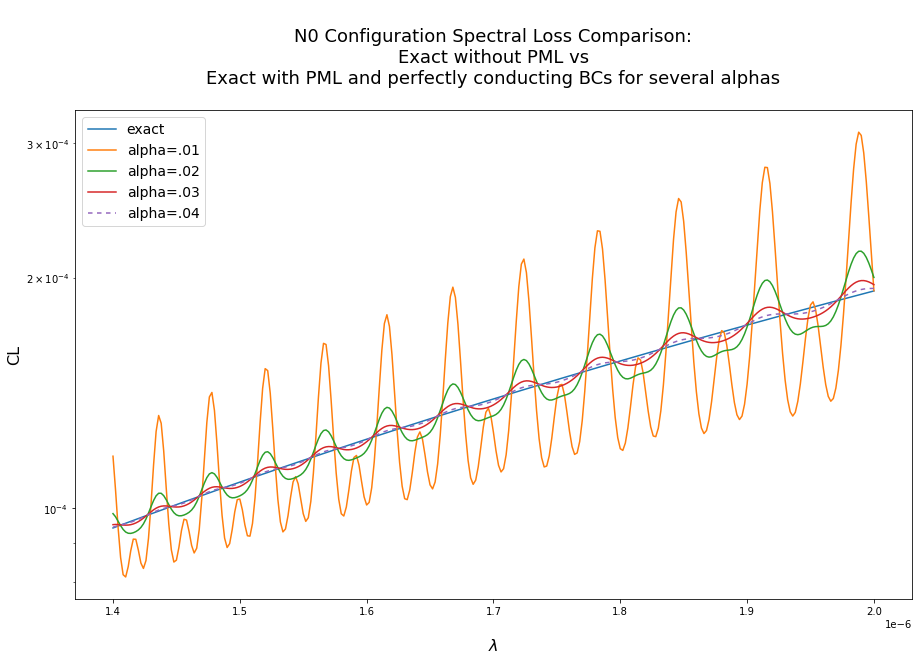

In [22]:
%matplotlib inline
plt.figure(figsize=(15,9))
plt.title('\nN0 Configuration Spectral Loss Comparison:\nExact without PML vs\nExact with PML and perfectly conducting BCs for several alphas\n',
         fontsize=18)
plt.plot(wls, -betas_reg.imag, linewidth=1.5, label='exact')
plt.plot(wls, -betas_pml2.imag, linewidth=1.5, label='alpha=.01')
plt.plot(wls, -betas_pml3.imag, linewidth=1.5, label='alpha=.02')
plt.plot(wls, -betas_pml4.imag, linewidth=1.5, label='alpha=.03')
plt.plot(wls, -betas_pml5.imag, linestyle=(0,(3,3)), linewidth=1.5, label='alpha=.04')

plt.ylabel('CL', fontsize=16)
plt.xlabel('\n$\lambda$', fontsize=16)

plt.yscale('log')
plt.legend(fontsize=14);

In [79]:
ts = [4.0775e-05, 1e-5, 1.5e-5]
rhos =[sum(ts[:i]) for i in range(1, len(ts)+1)]

mats = ['air', 'glass', 'glass']
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_glass]
maxhs = [6, 33, 44]
scale = 15e-6

pml = {'alpha':.05, 'R0':rhos[-2]}

betas_pml6 = np.zeros_like(wls, dtype=complex)
outer = 'pcb'

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    B = BraggExact(ts=ts, maxhs=maxhs, wl=wls[i], ns=ns, mats=mats, scale=scale, no_mesh=True)

    k_low = B.ks[0] * B.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(B.determinant, x0, args=(nu, outer, pml), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(B.determinant(beta, nu, outer, pml)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas_pml6[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.33269144210017-9.42862101035469e-05j) . Residual of determinant:  1.5296237764986506e-09 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23662253218144-9.454432928699411e-05j) . Residual of determinant:  3.809968482746656e-10 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14082729476641-9.479763245805837e-05j) . Residual of determinant:  1.2654066694323993e-09 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (67.045304560482-9.504786356065084e-05j) . Residual of determinant:  1.3362779155343688e-09 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.950053167

Scaled beta:  (63.86508198741555-0.00010483575189028776j) . Residual of determinant:  9.272637041422817e-10 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

Scaled beta:  (63.7786444814828-0.00010512152289459882j) . Residual of determinant:  4.1966956150214367e-10 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

Scaled beta:  (63.692440567548275-0.00010539875249637246j) . Residual of determinant:  2.648170615235261e-09 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (63.60646929724976-0.00010566796207258954j) . Residual of determinant:  8.020866487913073e-10 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.520729727600205-0.0001059304440083361j) . Residual of determinant:  1.0623317194820386e-10 


     --------------------  44/301: wavelength: 1.48599999

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.58088327884623-0.00011642190664940596j) . Residual of determinant:  2.3944537893540623e-10 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Scaled beta:  (60.50309920199818-0.00011676174747812446j) . Residual of determinant:  5.62328589129015e-10 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.42551456086859-0.00011709827839479491j) . Residual of determinant:  1.304458643073198e-09 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

Scaled beta:  (60.34812858814823-0.0001174287371248742j) . Residual of determinant:  6.353093526177043e-11 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scal

Scaled beta:  (57.54747748104458-0.00012877326860486905j) . Residual of determinant:  1.5447631882708942e-10 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

Scaled beta:  (57.4772809916198-0.0001290720520522255j) . Residual of determinant:  6.413957000391787e-11 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.407255481570445-0.00012938430755148173j) . Residual of determinant:  1.403275763074515e-10 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.337400329985385-0.00012971035952564594j) . Residual of determinant:  4.034350018179013e-10 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.26771491898728-0.00013004982605234252j) . Residual of determinant:  2.919612220238279e-10 


   

Scaled beta:  (54.86708602630515-0.0001421837595948014j) . Residual of determinant:  1.8229707041608742e-10 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

Scaled beta:  (54.80327057053049-0.00014255142333031255j) . Residual of determinant:  4.106291634287403e-10 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.73960333851747-0.0001429039468346359j) . Residual of determinant:  3.216440712283365e-10 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

Scaled beta:  (54.67608381077154-0.0001432399915581629j) . Residual of determinant:  3.9442645383404543e-10 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

Scaled beta:  (54.61271146995666-0.00014355910496382658j) . Residual of determinant:  3.7618406662855076e-11 


     --------------------  1

scaling guess: 1
scaling guess: 2
Scaled beta:  (52.42518802520891-0.00015541359130425192j) . Residual of determinant:  2.2890263261327052e-11 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

Scaled beta:  (52.366921224462025-0.00015566325059429814j) . Residual of determinant:  2.1451477810830588e-10 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

Scaled beta:  (52.308783724353-0.00015591667902376961j) . Residual of determinant:  2.0225643393204324e-10 


     --------------------  203/301: wavelength: 1.804e-06  --------------------     

Scaled beta:  (52.25077509592859-0.00015617752357385673j) . Residual of determinant:  3.622665365740205e-10 


     --------------------  204/301: wavelength: 1.806e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (52.192894912795346-0.00015644907389480097j) . Residual of determinant:  4.938416592549894e-10 


     --------------

scaling guess: 1
Scaled beta:  (50.29846857683209-0.0001682764633111414j) . Residual of determinant:  4.731135933890106e-11 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

Scaled beta:  (50.24482878729824-0.0001685850236589905j) . Residual of determinant:  1.3812665763598132e-10 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.19130322073214-0.0001689134280249533j) . Residual of determinant:  1.788149519840965e-11 


     --------------------  241/301: wavelength: 1.8799999999999998e-06  --------------------     

Scaled beta:  (50.13789151604225-0.0001692627256432457j) . Residual of determinant:  1.1298932249333358e-10 


     --------------------  242/301: wavelength: 1.882e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.08459331378578-0.00016963339751218043j) . Residual of determinant:  1.1126021281272375e-10 


     --------------------

scaling guess: 2
Scaled beta:  (48.337499512731966-0.00018196043248521504j) . Residual of determinant:  7.582089186757915e-11 


     --------------------  277/301: wavelength: 1.952e-06  --------------------     

Scaled beta:  (48.28795666084856-0.0001823349300644799j) . Residual of determinant:  9.170399476284024e-11 


     --------------------  278/301: wavelength: 1.954e-06  --------------------     

Scaled beta:  (48.238515211105636-0.00018273305685807825j) . Residual of determinant:  9.084068007359537e-11 


     --------------------  279/301: wavelength: 1.956e-06  --------------------     

Scaled beta:  (48.189174856085224-0.00018315446619077434j) . Residual of determinant:  1.3339575590990706e-10 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

Scaled beta:  (48.139935289581544-0.000183598300899773j) . Residual of determinant:  1.298195472468716e-10 


     --------------------  281/301: wavelength: 1.96e-06  -----------

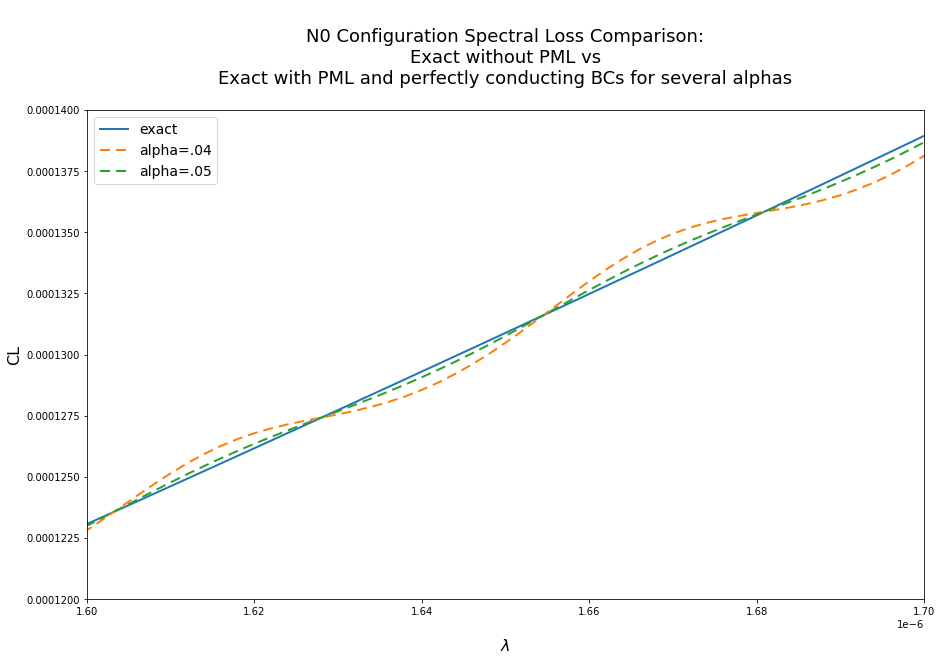

In [104]:
%matplotlib inline
plt.figure(figsize=(15,9))
plt.title('\nN0 Configuration Spectral Loss Comparison:\nExact without PML vs\nExact with PML and perfectly conducting BCs for several alphas\n',
         fontsize=18)
plt.plot(wls, -betas_reg.imag, linewidth=2, label='exact')
# plt.plot(wls, -betas_pml2.imag, linewidth=1.5, label='alpha=.01')
# plt.plot(wls, -betas_pml3.imag, linewidth=1.5, label='alpha=.02')
# plt.plot(wls, -betas_pml4.imag, linewidth=1.5, label='alpha=.03')
plt.plot(wls, -betas_pml5.imag, linestyle=(0,(5,3)), linewidth=2, label='alpha=.04')
plt.plot(wls, -betas_pml6.imag, linestyle=(0,(5,3)), linewidth=2, label='alpha=.05')

plt.ylabel('CL', fontsize=16)
plt.xlabel('\n$\lambda$', fontsize=16)
plt.xlim(1.6e-6, 1.7e-6)
plt.ylim(.00012, .00014)
# plt.yscale('log')
plt.legend(fontsize=14);